In [65]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BY1Wyq7_pAaf57ZIZ9rcdb2LD29Kgmz5' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BY1Wyq7_pAaf57ZIZ9rcdb2LD29Kgmz5" -O files.zip && rm -rf ~/cookies.txt

--2022-03-16 17:58:45--  https://docs.google.com/uc?export=download&confirm=t&id=1BY1Wyq7_pAaf57ZIZ9rcdb2LD29Kgmz5
Resolving docs.google.com (docs.google.com)... 172.217.0.46, 2607:f8b0:4004:800::200e
Connecting to docs.google.com (docs.google.com)|172.217.0.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nnt24816f29mo1af59mtfl5nbhiqhers/1647453525000/09977954582062536659/*/1BY1Wyq7_pAaf57ZIZ9rcdb2LD29Kgmz5?e=download [following]
--2022-03-16 17:58:45--  https://doc-04-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nnt24816f29mo1af59mtfl5nbhiqhers/1647453525000/09977954582062536659/*/1BY1Wyq7_pAaf57ZIZ9rcdb2LD29Kgmz5?e=download
Resolving doc-04-3g-docs.googleusercontent.com (doc-04-3g-docs.googleusercontent.com)... 142.251.33.193, 2607:f8b0:4004:837::2001
Connecting to doc-04-3g-docs.googleusercontent.com (doc-04-3g-docs.googleu

In [66]:
!unzip files.zip

Archive:  files.zip
replace data/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable, Function
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import wheel
import functools
import urllib
import cv2
import numpy as np
import os
import sys
import math
import random
from glob import glob
from scipy.ndimage.filters import gaussian_filter
from IPython.display import clear_output, Image, display, HTML
from google.protobuf import text_format
from io import StringIO
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['image.interpolation'] = 'nearest' # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray' # use grayscale output rather than a (potentially misleading) color heatmap

### Model

In [139]:
class VGG11Backbone(nn.Module):

    def __init__(self):
        super(VGG11Backbone, self).__init__()

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(512)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = self.relu(x)
        x = self.conv3_2(x)
        x = self.bn3_2(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = self.conv4_1(x)
        x = self.bn4_1(x)
        x = self.relu(x)
        x = self.conv4_2(x)
        x = self.bn4_2(x)
        x = self.relu(x)
        x = self.pool4(x)

        x = self.conv5_1(x)
        x = self.bn5_1(x)
        x = self.relu(x)
        x = self.conv5_2(x)
        x = self.bn5_2(x)
        x = self.relu(x)

        return x   

In [140]:
class VGG11Classification(nn.Module):

    def __init__(self, num_classes=7):
        super(VGG11Classification, self).__init__()

        self.backbone = VGG11Backbone()
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc_out = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.backbone(x)
        x = self.pool5(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc_out(x)

        return x

In [141]:
# loading model
model_root = './model.pth'

model = VGG11Classification()
model.load_state_dict(torch.load(model_root))

<All keys matched successfully>

# Visualizing structure

In [142]:
for name, module in model.named_parameters():
    print(name)

backbone.conv1.weight
backbone.conv1.bias
backbone.bn1.weight
backbone.bn1.bias
backbone.conv2.weight
backbone.conv2.bias
backbone.bn2.weight
backbone.bn2.bias
backbone.conv3_1.weight
backbone.conv3_1.bias
backbone.bn3_1.weight
backbone.bn3_1.bias
backbone.conv3_2.weight
backbone.conv3_2.bias
backbone.bn3_2.weight
backbone.bn3_2.bias
backbone.conv4_1.weight
backbone.conv4_1.bias
backbone.bn4_1.weight
backbone.bn4_1.bias
backbone.conv4_2.weight
backbone.conv4_2.bias
backbone.bn4_2.weight
backbone.bn4_2.bias
backbone.conv5_1.weight
backbone.conv5_1.bias
backbone.bn5_1.weight
backbone.bn5_1.bias
backbone.conv5_2.weight
backbone.conv5_2.bias
backbone.bn5_2.weight
backbone.bn5_2.bias
fc_out.weight
fc_out.bias


In [145]:
for name, module in model.named_parameters():
    
    names = name.split(".")
    if 'backbone' in name:
        n = names[1]
    else:
        n = names[0]

    if 'weight' in name:
        print(f'Module {n}\n\tweights: {module.size()}')
    if 'bias' in name:
        print(f'\tbias: {module.size()}')

Module conv1
	weights: torch.Size([64, 3, 3, 3])
	bias: torch.Size([64])
Module bn1
	weights: torch.Size([64])
	bias: torch.Size([64])
Module conv2
	weights: torch.Size([128, 64, 3, 3])
	bias: torch.Size([128])
Module bn2
	weights: torch.Size([128])
	bias: torch.Size([128])
Module conv3_1
	weights: torch.Size([256, 128, 3, 3])
	bias: torch.Size([256])
Module bn3_1
	weights: torch.Size([256])
	bias: torch.Size([256])
Module conv3_2
	weights: torch.Size([256, 256, 3, 3])
	bias: torch.Size([256])
Module bn3_2
	weights: torch.Size([256])
	bias: torch.Size([256])
Module conv4_1
	weights: torch.Size([512, 256, 3, 3])
	bias: torch.Size([512])
Module bn4_1
	weights: torch.Size([512])
	bias: torch.Size([512])
Module conv4_2
	weights: torch.Size([512, 512, 3, 3])
	bias: torch.Size([512])
Module bn4_2
	weights: torch.Size([512])
	bias: torch.Size([512])
Module conv5_1
	weights: torch.Size([512, 512, 3, 3])
	bias: torch.Size([512])
Module bn5_1
	weights: torch.Size([512])
	bias: torch.Size([512])


### Model test

In [143]:
class TestModel(nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        def forward(self, x):
            
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.pool1(x)

            return x

test_model = TestModel()

print(test_model)

for name, module in test_model.named_parameters():
    print(name)

TestModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
conv1.weight
conv1.bias
bn1.weight
bn1.bias


In [144]:
class TestModel2(nn.Module):
    def __init__(self):
        super(TestModel2, self).__init__()

        def forward(self, x):

            x = nn.Conv2d(3, 64, kernel_size=3, padding=1)(x)
            x = nn.BatchNorm2d(64)(x)
            x = nn.ReLU(inplace=True)(x)
            x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

            return x

test_model_2 = TestModel2()

print(test_model_2)

for name, module in test_model_2.named_parameters():
    print(name)

TestModel2()


# get_module_params_num

In [146]:
def get_module_params_num(module):

    param_num = 0

    for _, param in module.named_parameters():

        param_size = 1

        for size in list(param.size()):
            param_size *= size

        param_num += param_size

    return param_num

def get_model_params_num(model):

    module_num = 0

    for name, module in model._modules.items():
        module_num += get_module_params_num(module)

    return module_num

In [147]:
num_params = get_model_params_num(model)
print(num_params)

9229575


# Visualizing conv1 filters

- 첫번째 conv layer의 filter를 시각화
- conv1 layer의 weight를 conv1_filters_data에 할당

In [148]:
def plot_filters(data, title=None):

    if data.size(1)>3:
        data = data.view(-1, 1, data.size(2), data.size(3))

    data = image_tensor_to_numpy(data)

    # normalize data
    data = (data-data.min()) / (data.max()-data.min())

    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n**2-data.shape[0]), (0, 2), (0, 2)) + ((0, 0),) * (data.ndim-3)) 
    # padding = ((0, 0), (0, 2), (0, 2), (0, 0))

    data = np.pad(data, padding, mode='constant', constant_values=1) # pad with ones

    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim+1)))
    data = data.reshape((n*data.shape[1], n*data.shape[3]) + data.shape[4:])
    data = data.squeeze()

    # plot
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.title(title)
    plt.imshow(data)

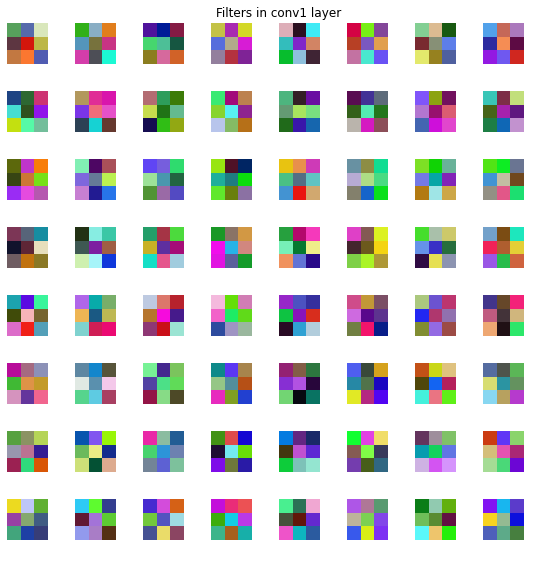

In [149]:
conv1_filters_data = model.backbone.conv1.weight.data

plot_filters(conv1_filters_data, title='Filters in conv1 layer')

# Visualizing model activations using forward hook

In [150]:
plot_activations = plot_filters

In [151]:
activation_list = []

def show_activations_hook(name, module, input, output):

    if output.dim()==4:

        activation_list.append(output)
        plot_activations(output, f'Activations on: {name}')

### Dataset

In [152]:
class MaskDataset(Dataset):

    def __init__(self, data_root, input_size=224, transform=None, shuffle=False):
        super(MaskDataset, self).__init__()

        self.img_list = sorted(glob(os.path.join(data_root, '*.jpg')))
        self.len = len(self.img_list)
        self.input_size = input_size
        self.transform = transform

    def __getitem__(self, index):

        img_path = self.img_list[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img/225.

        if self.transform:
            img = self.transform(img)

        return img

    def __len__(self):

        return self.len

In [153]:
data_root = './data'
input_size = 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

mask_dataset = MaskDataset(data_root, input_size=input_size, transform=transform)

### Image converter

In [154]:
def image_tensor_to_numpy(tensor_image):

    # If this is already a numpy image, just return it
    if type(tensor_image)==np.ndarray:
        return tensor_image

    # Make sure this is a tensor and not a variable
    if type(tensor_image)==Variable:
        tensor_image = tensor_image.data

    # Convert to numpy and move to CPU if necessary
    np_img = tensor_image.detach().cpu().numpy()
    
    # If there is no batch dimension, add one
    if len(np_img.shape)==3:
        np_img = np_img[np.newaxis, ...]

    # Convert from BxCxHxW (PyTorch convention) to BxHxWxC (OpenCV/numpy convention)
    np_img = np_img.transpose(0, 2, 3, 1)

    return np_img

def image_numpy_to_tensor(np_image):

    if len(np_image.shape)==3:
        np_image - np_image[np.newaxis, ...]

    # Convert from BxHxWxC (OpenCV/numpy) to BxCxHxW (PyTorch)
    np_image = np_image.transpose(0, 3, 1, 2)

    tensor_image = torch.from_numpy(np_image).float()

    return tensor_image   

### Image drawer

In [155]:
def normalize(tensor):

    x = tensor - tensor.min()
    x = x / (x.max()+1e-9)

    return x

def draw_border(image_np, color):

    color = np.asarray(color)
    s = image_np.shape
    image_np = image_np.copy()
    image_np[0:5, :, :] = color[np.newaxis, np.newaxis, :]
    image_np[:, 0:5, :] = color[np.newaxis, np.newaxis, :]
    image_np[s[0]-5:s[0], :, :] = color[np.newaxis, np.newaxis, :]
    image_np[:, s[0]-5:s[0], :] = color[np.newaxis, np.newaxis, :]
    
    return image_np

def show_image(image, title=None):
    
    np_img = image_tensor_to_numpy(image)
    if len(np_img.shape)>3:
        np_img = np_img[0]
    np_img = normalize(np_img)

    np_img = np_img.squeeze()
    plt.figure(figsize=(4,4))
    plt.imshow(np_img)
    plt.axis('off')
    if title: 
        plt.title(title)
    plt.show()

def show_images(image_list):

    for l in image_list:
        f, axarr = plt.subplots(1, len(l))

        for i, img in enumerate(l):
            np_img = image_tensor_to_numpy(img)

            if len(np_img.shape)>3:
                np_img = np_img[0]

            np_img = normalize(np_img)
            np_img = np_img.squeeze()

            axarr[i].imshow(np_img)
            axarr[i].axis('off')

        plt.show()

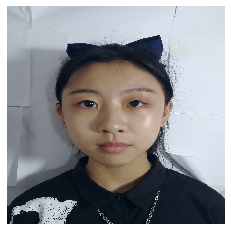

In [156]:
img = mask_dataset[0]
show_image(img)

In [157]:
img = Variable(img[np.newaxis, ...])
img = img.double()

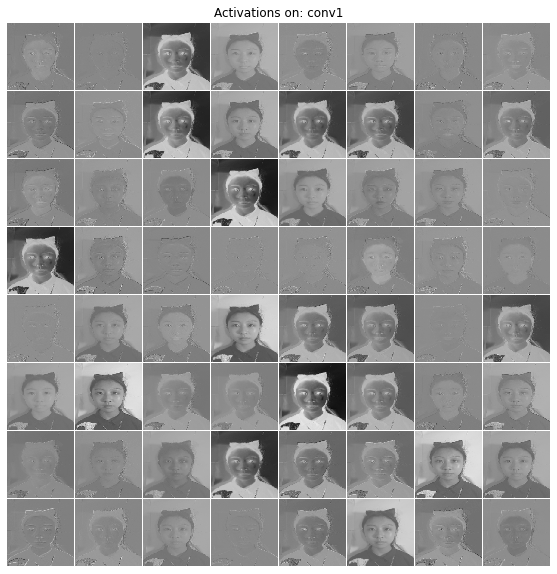

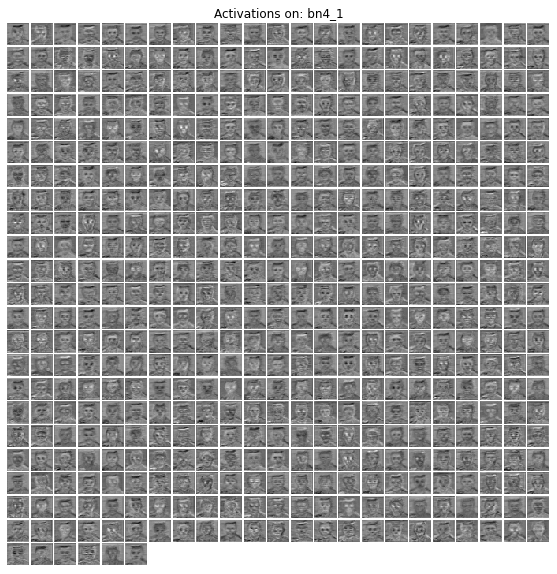

In [167]:
# Re-define the model to clear any previously registered hooks
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))

model.double()

module_list = [model.backbone.conv1, model.backbone.bn4_1]
module_names = ['conv1', 'bn4_1']

for idx, (name, module) in enumerate(zip(module_names, module_list)):

    hook = functools.partial(show_activations_hook, name)
    module.register_forward_hook(hook)

_ = model(img)

In [166]:
np.shape(activation_list[0])

torch.Size([1, 64, 224, 224])

# Visualizing saliency

${\partial s_y \over \partial I}$

$s_y$: class $y$에 대한 logit

$I$: 이미지

In [168]:
def compute_gradient_score(scores, image, class_idx):
    # returns ds_y / d_I
    # s_y: the score(=logit) at index class_idx
    # I: input image

    s_y = scores[class_idx]
    s_y.backward()

    grad = torch.zeros_like(image)
    grad = image.grad

    assert tuple(grad.shape)==(1, 3, 224, 224)

    return grad[0]

In [169]:
def visualize_saliency(image, model):

    input = Variable(image.unsqueeze(0), requires_grad=True)
    
    output = model(input)[0]

    max_score, max_idx = torch.max(output, 0)

    grad = compute_gradient_score(output, input, max_idx)

    vis = grad**2
    vis, _ = torch.max(vis, 0)

    return vis

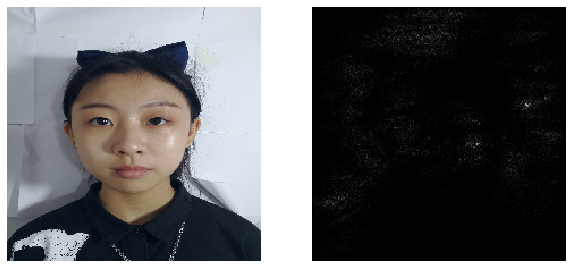

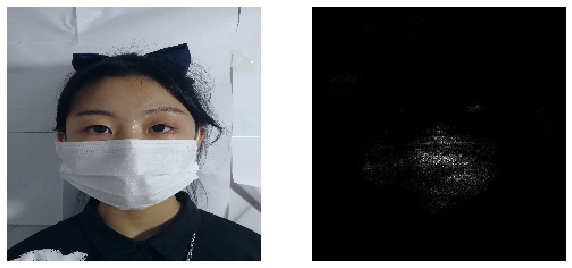

In [170]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))
model.double()

input_images = []
saliency_maps = []

for _, sample in enumerate(mask_dataset):

    saliency_map = visualize_saliency(sample, model)
    assert list(saliency_map.shape)==[224, 224]

    saliency_maps.append(saliency_map.unsqueeze(0))
    input_images.append(sample)

row_list = list(zip(input_images, saliency_maps))
show_images(row_list)

# Visualizing Grad-CAM

$\alpha_c^k = {\partial y^c \over \partial A^k}$

$y^c$: class $c$에 대한 score

$A^k$: target layer인 $k$-th feature map의 activation

$ ReLU (\sum_k \alpha_c^k A^k) $

In [173]:
save_feat = []
def hook_feat(module, input, output):
    save_feat.append(output)
    return output

save_grad = []
def hook_grad(grad):
    save_grad.append(grad)
    return grad

def vis_gradcam(vgg, img):

    vgg.eval()

    # register hook to store layer activation of the target layer
    vgg.backbone.bn5_2.register_forward_hook(hook_feat)

    # forward pass to hook features
    img = img.unsqueeze(0)
    s = vgg(img)[0]

    # register hook to store gradients
    save_feat[0].register_hook(hook_grad)

    # backward score
    y = torch.argmax(s).item()
    s_y = s[y]
    s_y.backward()

    # compute activation at global-average-pooling layer
    gap_layer = torch.nn.AdaptiveAvgPool2d(1)
    alpha = gap_layer(save_grad[0][0].squeeze())
    A = save_feat[0].squeeze()

    # compute grad_CAM
    relu_layer = torch.nn.ReLU()
    weighted_sum = torch.sum(alpha*A, dim=0)
    grad_CAM = relu_layer(weighted_sum)
    grad_CAM = grad_CAM.unsqueeze(0)
    grad_CAM = grad_CAM.unsqueeze(0)

    # upscale grad_CAM
    upscale_layer = torch.nn.Upsample(scale_factor=img.shape[-1]/grad_CAM.shape[-1], mode='bilinear')
    grad_CAM = upscale_layer(grad_CAM)
    grad_CAM = grad_CAM / torch.max(grad_CAM)

    # plot
    img_np = image_tensor_to_numpy(img)
    if len(img_np.shape)>3:
        img_np = img_np[0]
    img_np = normalize(img_np)
    grad_CAM = grad_CAM.squeeze().detach().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.imshow(grad_CAM, cmap='jet', alpha = 0.5)
    plt.show

    return grad_CAM

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


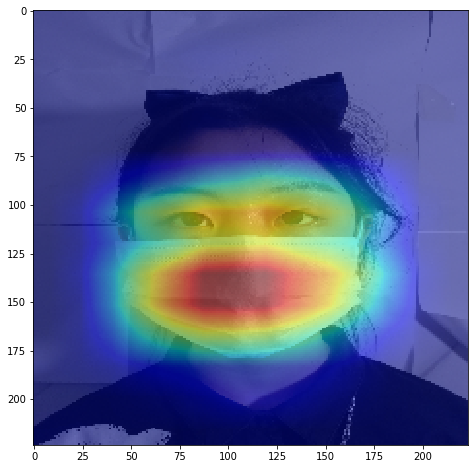

In [174]:
model = VGG11Classification()
model.load_state_dict(torch.load(model_root))
model.double()

img = mask_dataset[1]
res = vis_gradcam(model, img)